In [1]:

import random
import time
import warnings
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib.image import imread
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision.utils import save_image
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore")
seed = 42
sns.set()


### Read and preprocessed the data

In [2]:

data_path = Path('../input/retail-product-checkout-dataset')
csv_path = Path('../input/rpc-df3/rpc_train_dataframe_super.csv')

data = pd.read_csv(csv_path)
data = data.rename(columns={'supercategory_id':'labels'})
data = data.rename(columns={'bbox':'bboxes'})
print(f'Column names: {list(data)}')
data['labels'].astype('int64')
data = data.set_index('image_id')
mapping = data.groupby(['labels','supercategory']).size().reset_index().rename(columns={0:'count'})


train_data, val_data = train_test_split(data,
                                        test_size=0.1, shuffle=True, random_state=seed)
num_classes = train_data['labels'].nunique()
print(f'There are {num_classes} classes in training data')
mapping


Column names: ['Unnamed: 0', 'file_name', 'image_id', 'area', 'bboxes', 'category_id', 'iscrowd', 'segmentation', 'point_xy', 'supercategory', 'sku_name', 'shelf', 'num', 'name_y', 'clas', 'known', 'labels']
There are 17 classes in training data


,labels,supercategory,count
0,0,alcohol,1759
1,1,candy,3040
2,2,canned_food,2238
3,3,chocolate,4320
4,4,dessert,5278
5,5,dried_food,2875
6,6,dried_fruit,2873
7,7,drink,2400
8,8,gum,2240
9,9,instant_drink,2878


In [3]:

def text_label(index):
    return mapping.loc[mapping['labels'] == index, 'supercategory'].iloc[0]

## **Create Pytorch dataset**

In [4]:

from albumentations import BboxParams, Compose, OneOf, Resize, RGBShift, \
    RandomBrightnessContrast, Rotate, \
    Normalize, ShiftScaleRotate, HorizontalFlip, VerticalFlip, CenterCrop, \
    RandomSizedBBoxSafeCrop, Blur, ColorJitter, RandomGamma, \
    Cutout
from albumentations.augmentations.bbox_utils import convert_bbox_from_albumentations
from albumentations.augmentations.transforms import Equalize
from albumentations.imgaug.transforms import IAAAffine
from albumentations.pytorch import ToTensorV2


image_height, image_width = 128, 128

dataset_format = 'pascal_voc'
bbox_params=BboxParams(format=dataset_format,
                       min_visibility=0.3,
                       label_fields=['labels'])

train_augment = Compose([
                          OneOf([
                              RGBShift(r_shift_limit=15, g_shift_limit=15,
                                       b_shift_limit=15, p=0.5),
                              RandomBrightnessContrast(brightness_limit=0.1,
                                                       contrast_limit=0.05),
                              Equalize(p=0.1),
                              RandomGamma(p=0.5),
                              ColorJitter(p=0.5),
                          ], p=0.9),
                          OneOf([
                              ShiftScaleRotate(shift_limit=0.1625,
                                               scale_limit=0.1,
                                               rotate_limit=20,
                                               interpolation=1,
                                               border_mode=4, p=0.9),
                          ], p=0.6),

                          OneOf([
                              Blur(blur_limit=3, p=0.1),
                              Cutout(num_holes=8, max_h_size=5,
                                     max_w_size=5, fill_value=0, p=0.3),
                              
                          ], p=0.2),
                        ],
                         bbox_params=bbox_params)

transform = Compose([ 
    Resize(image_height, image_width),
    Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    ToTensorV2(),
], bbox_params=bbox_params)


In [5]:

class ProductDataset(Dataset):
    def __init__(self, data_dir, images_info_df, augment=None, transform=None):
        self.data_dir = data_dir
        self.data = images_info_df 
        self.augment = augment
        self.transform = transform

    def check_min(self, value):
        if value > 0:
            return value
        return 0
    
    def check_max(self, value, max_value):
        if value < max_value:
            return value
        return max_value
    
    def resize(self, image, bboxes, env_size=0.2):
        [x, y, w, h] = bboxes
        im_h, im_w, im_c = image.shape

        if w > h:
            x_max = int(self.check_max(x + (w * env_size) + w, im_w))
            x_min = int(self.check_min(x - (w * env_size)))
            new_w = (x_max - x_min) / 2
            y_mid = (y + (y + h)) / 2
            y_max = int(self.check_max(y_mid + new_w, im_h))
            y_min = int(self.check_min(y_mid - new_w))
        else:
            y_max = int(self.check_max(y + (h * env_size) + h, im_h))
            y_min = int(self.check_min(y - (h * env_size)))
            new_h = (y_max - y_min) / 2 
            x_mid = (x + (x + w)) / 2
            x_max = int(self.check_max(x_mid + new_h, im_w))
            x_min = int(self.check_min(x_mid - new_h))
            
        if y_min < 0 or x_min < 0:
            print(x, y, w, h, x_min, y_min, x_max, y_max)
            print(bboxes)
            
        image = image[y_min:y_max, x_min:x_max, :]
        bboxes = np.array([x - x_min, y - y_min, w, h])
        return image, bboxes
    
    def convert_format(self, res):
        xmin, ymin, width, height = res["bboxes"][0], res["bboxes"][1], \
                res["bboxes"][2], res["bboxes"][3] 
        xmax, ymax = xmin + width, ymin + height
        img_h, img_w = res['image'].shape[0], res['image'].shape[1]
        res["bboxes"] = convert_bbox_from_albumentations(bbox=(xmin / img_w,
                                                               ymin / img_h,
                                                               xmax / img_w,
                                                               ymax / img_h),
                                target_format=dataset_format,
                                rows=img_h, cols=img_w, check_validity=True)
        return res

    def __getitem__(self, i, apply_augmentations=True,
                    apply_transformations=True):
        record = self.data.iloc[i]

        image = cv2.imread(str(self.data_dir / record['file_name']), 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        bboxes = np.array(record['bboxes'][1:-1].split(',')).astype('float')

        image, bboxes = self.resize(image, bboxes)

        labels = np.array(record['labels']).astype('int64')

        res = {"image": image,
               "bboxes": torch.tensor(bboxes, dtype=torch.float),
               "labels": torch.tensor(np.array([labels])),
              }
        # convert bounding boxes to 'pascal_voc' format
        res = self.convert_format(res)
        res["bboxes"] = torch.tensor(res["bboxes"]).reshape((1, -1))

        if self.augment and apply_augmentations:
            res = self.augment(**res)

        if self.transform and apply_transformations:
            res = self.transform(**res)

        return res["image"], {
            "boxes": torch.tensor(res["bboxes"], dtype=torch.float),
            "labels": torch.tensor(res["labels"], dtype=torch.int64),
        }   

    def __len__(self):
        return len(self.data)


In [6]:
train_dataset = ProductDataset(data_path / 'train2019', train_data,
                              augment=train_augment, transform=transform)
val_dataset = ProductDataset(data_path / 'train2019', val_data,
                              augment=None, transform=transform)
print(len(train_dataset), len(val_dataset))

48365 5374


### **Visualize dataset**

In [7]:

def get_grid_size(imgs_num, nrows, ncols):
    from math import ceil
    if nrows is None and ncols is None:
        nrows = 1
        ncols = imgs_num
    elif nrows is None:
        nrows = ceil(imgs_num / ncols)
    elif ncols is None:
        ncols = ceil(imgs_num / nrows)
    return nrows, ncols

def plot_detection_boxes(img, detection_boxes, detection_labels,
                         dataset_format=None, verbose=False):
    if verbose:
        print(f'Dislay in {dataset_format} format')
    # `coco` format: `(x_min, y_min, width, height)`
    # `pascal_voc`format:`(x_min, y_min, x_max, y_max)`
    # `yolo` format :`(x, y, width, height)`
    for box, label in zip(detection_boxes, detection_labels):
        if dataset_format == 'coco':
            # round values only for visualization (opencv requirement)
            xmin, ymin, width, height = int(box[0]), int(box[1]), \
                                        int(box[2]), int(box[3])
            img = cv2.rectangle(np.array(img), (xmin, ymin + height),
                                (xmin + width, ymin), (0,255,0), 3)
        elif dataset_format == 'pascal_voc':
            xmin, ymin, xmax, ymax = int(box[0]), int(box[1]), \
                                     int(box[2]), int(box[3])
            img = cv2.rectangle(np.array(img), (xmin, ymax), (xmax, ymin),
                                (0,255,0), 3)
        else:
            raise ValueError(f'Please specify a format of bounding boxes as '
                             f'dataset_format parameter. Currently supported '
                             f'formats are "coco" and "pascal_voc"')
        scale = 0.3 # (0,1] to change text size relative to the image
        fontScale = min(img.shape[1],img.shape[0])/(150/scale)
        img = cv2.putText(img, text=str(label), org=(xmin, ymin),
                          fontFace=3, fontScale=fontScale, color=(0, 0, 0))
    return img


def plot_images(imgs, names=None, axs=None, show=True, nrows=None, ncols=None,
                figsize=(16, 8), mode=None, detection_boxes=None,
                detection_labels=None, dataset_format=None, pic_name=None):
    nrows, ncols = get_grid_size(len(imgs), nrows, ncols)

    if axs is None:
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    if nrows == 1 and ncols == 1:
        if mode == 'detection':
            imgs[0] = plot_detection_boxes(imgs[0], detection_boxes,
                                           detection_labels,
                                           dataset_format=dataset_format)
        axs.imshow(imgs[0])
        axs.set_axis_off()
        if names and len(names) > 0:
            axs.set_title(names[0], fontsize=15)
        if pic_name:
            pass
            # axs.imsave(f'{pic_name}.jpg', imgs[0])
    elif nrows == 1 or ncols == 1:
        for j, ax in enumerate(axs):
            if mode == 'detection':
                if ncols == 1:
                    imgs[j] = plot_detection_boxes(imgs[j],
                                                   [detection_boxes[j]],
                                                   [detection_labels[j]],
                                                dataset_format=dataset_format)
                elif nrows == 1:
                    imgs[j] = plot_detection_boxes(imgs[j],
                                                   [detection_boxes[j]],
                                                   [detection_labels[j]],
                                               dataset_format=dataset_format)
            ax.imshow(imgs[j])
            ax.set_axis_off()
            if names and j < len(names):
                ax.set_title(names[j], fontsize=15)
    else:
        for j, ax in enumerate(axs):
            for k, sub_ax in enumerate(ax):
                image_id = j * ncols + k
                sub_ax.set_axis_off()
                if image_id < len(imgs):
                    if mode == 'detection':
                        imgs[image_id] = plot_detection_boxes(imgs[image_id],
                                                [detection_boxes[image_id]],
                                                [detection_labels[image_id]],
                                                dataset_format=dataset_format)
                    sub_ax.imshow(imgs[image_id])        
                    if names and image_id < len(names):
                        sub_ax.set_title(names[image_id], fontsize=15)
    if show:
        plt.show()


In [8]:

def show_dataset(dataset, sample_size=3, n=6, show_augmentations=True):
    idx = [np.random.choice(np.arange(dataset.__len__())) for i in range(sample_size)]
    imgs = []
    names = ['original']
    detection_boxes = []
    detection_labels = []

    for index in idx:
        item = dataset.__getitem__(index, apply_augmentations=False,
                                   apply_transformations=False)
        img = item[0]
        annotations_true = item[1]
        true_boxes, true_labels = list(annotations_true['boxes'].numpy()[0]), \
                                  list(annotations_true['labels'].numpy())[0]
        label_names = text_label(true_labels)
        imgs.append(img)
        detection_boxes.append(true_boxes)
        detection_labels.append(label_names)

        if show_augmentations:
            for _ in range(n-1):
                augmented = dataset.__getitem__(index,
                                                apply_augmentations=True,
                                                apply_transformations=False)
                img_augmented = augmented[0]
                if len(augmented) > 1 and len(augmented[1]["boxes"]) > 0:
                    annotations = augmented[1]
                    boxes_augmented = list(augmented[1]["boxes"].numpy()[0])
                    labels_augmented = list(augmented[1]["labels"].numpy())[0]
                    label_names = text_label(labels_augmented)

                    imgs.append(img_augmented)
                    detection_boxes.append(boxes_augmented)
                    detection_labels.append(label_names)
    if show_augmentations:
        aug = ['augmented' for _ in range(n-1)]
        names = names + aug
    plot_images(imgs, nrows=sample_size, ncols=n, mode='detection',
                names=names, detection_boxes=detection_boxes,
                detection_labels=detection_labels,
                dataset_format=dataset_format)



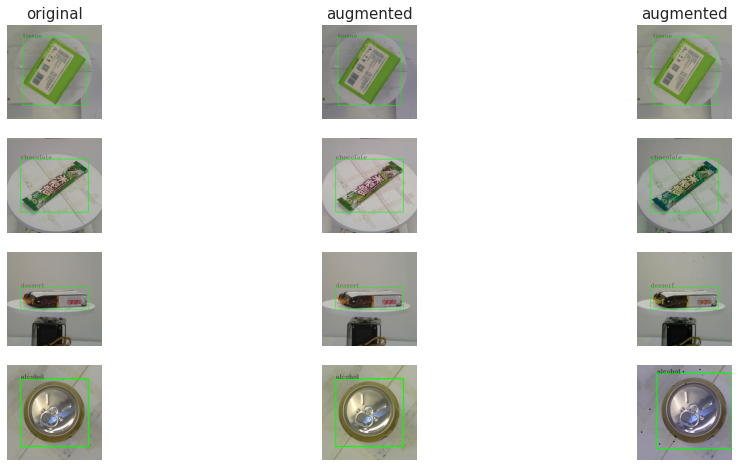

In [9]:
show_dataset(train_dataset, sample_size=4, n=3) 

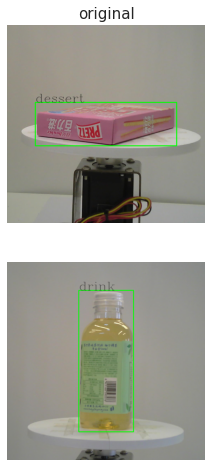

In [10]:
show_dataset(val_dataset, sample_size=2, n=1) 


### Code for model performance evaluation and training


In [11]:
def visualize():
    """
    This function will only execute if `DEBUG` is `True` in 
    `config.py`.
    """
    images, targets, image_ids = next(iter(train_data_loader))
    images = list(image for image in images)
    targets = [{k: v for k, v in t.items()} for t in targets]
    for i in range(1):
        boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
        sample = images[i].permute(1,2,0).cpu().numpy()
        fig, ax = plt.subplots(1, 1, figsize=(15, 12))
        for box in boxes:
            cv2.rectangle(sample,
                        (box[0], box[1]),
                        (box[2], box[3]),
                        (220, 0, 0), 3)
        ax.set_axis_off()
        plt.imshow(sample)
        plt.show()

In [12]:

def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1], i.e. xmin, ymin, xmax, ymax
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou


In [13]:
def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    
    gt_bboxes = target_true["boxes"].numpy()  # ground truth 
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()  # detected 
    dt_labels = target_pred["labels"].numpy()
    
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]
        
        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)): 
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]
            
            if gt_label != dt_label:
                continue
            
            iou_current = intersection_over_union(dt_bbox, gt_bbox)
            if iou_current > max_IoU:
                max_IoU = iou_current
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results

In [14]:

def evaluate(model, test_loader, device='cuda'):
    results = [] 
    model.eval()
    nbr_boxes = 0
    num_batches = len(test_loader)
    
    with torch.no_grad():
        for images, targets_true in tqdm(test_loader, total=num_batches):
            images = torch.stack(images).to(device)
            targets_true = [{k: v.to(device) for k, v in t.items()} for t in targets_true]
                    
            targets_pred = model(images)
        
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)): 
                target_true = targets_true[i] 
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))
    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))
    
    if results is not None: 
        if results[0]["TP"] == 1:
            acc_TP[0] = 1
        else:
            acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)


In [15]:

def train(model, optimizer, train_dataloader):
    model.train()
    running_loss = 0
    num_batches = len(train_dataloader)

    pbar = tqdm(enumerate(train_dataloader), total=num_batches)
    for i, (images, targets) in pbar:
        optimizer.zero_grad()

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())
        loss.backward()
        optimizer.step()
        scheduler.step() # Cyclic LRs after each batch

        running_loss += loss.item()
        pbar.set_description_str(f'loss: {running_loss / (i+1):.3f}',
                                 refresh=False)
    train_loss = running_loss / len(train_dataloader.dataset)
    return train_loss

def save_model(model_save_path):
    torch.save(model.state_dict(), Path(model_save_path))


In [16]:

def get_detection_model(num_classes, pretrained=True):
    model = fasterrcnn_resnet50_fpn(pretrained=pretrained, min_size=256, max_size=448)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one 
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def collate_fn(batch):
    return tuple(zip(*batch))


In [17]:

BATCH_SIZE = 4

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,
    collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2,
    collate_fn=collate_fn)

print(len(train_dataloader), len(train_dataset))
print(len(val_dataloader), len(val_dataset))


12092 48365
1344 5374


## Train a model

In [18]:

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_detection_model(num_classes+1, pretrained=True).to(device)
params = [v for k, v in model.named_parameters() if v.requires_grad]

max_lr = 1e-1
optimizer = torch.optim.SGD(params, lr=max_lr, momentum=0.9, weight_decay=0.0005)

# # Train for 1 epoch to make model's predictions more confident
# n_epochs = 1
# for epoch in range(n_epochs):
#     start = time.time()
#     train_loss = train(model, optimizer, train_dataloader)
#     print(f"Epoch #{epoch} loss: {train_loss}")
#     end = time.time()
#     print(f"Took {(end - start) / 60} minutes for epoch {epoch}")
# save_model('fasterrcnn_resnet50_fpn_1_epoch.pth')


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [19]:
# Train more


optimizer = torch.optim.SGD(params, lr=max_lr, momentum=0.9, weight_decay=0.0005)

num_batches_train = len(train_dataloader)
n_epochs = 5
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=n_epochs, steps_per_epoch=num_batches_train) 

# todo remove commented
# model_path = Path('../input/last-of-mohecan/fasterrcnn_resnet50_fpn_mon.pth')
model_path = Path('fasterrcnn_resnet50_fpn_1_epoch.pth')
model = get_detection_model(num_classes+1, pretrained=False).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
path_to_model_new = Path('fasterrcnn_resnet50_fpn_submit.pth')

model = model.to(device)
best_val_auc = 0.0
n_epochs = 5

for epoch in range(n_epochs):
    model.eval()
    val_auc = evaluate(model, val_dataloader, device=device)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        save_model(path_to_model_new)
    print(f'Epoch {epoch}. AUC ON TEST: {round(float(val_auc), 4)}')
    
    model.train() 
    train_loss = train(model, optimizer, train_dataloader)
    



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

  0%|          | 0/1344 [00:00<?, ?it/s]

Epoch 0. AUC ON TEST: 0.9521


  0%|          | 0/12092 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Final evaluation

In [20]:

num_batches = len(val_dataloader)
images, targets_true, outputs = [], [], []

model.eval()
with torch.no_grad():
    for batch_i, (valid_images, targ_true) in tqdm(enumerate(val_dataloader), total=num_batches):
        imgs = torch.stack(valid_images).to(device)
        
        images += [image for image in valid_images]
        targets_true += [{k: v.to(device) for k, v in t.items()} for t in targ_true]

        cpu_device = torch.device("cpu")
        outs = model(imgs)
        
        outputs += [{k: v.to(cpu_device) for k, v in t.items()} for t in outs]


  0%|          | 0/1344 [00:00<?, ?it/s]

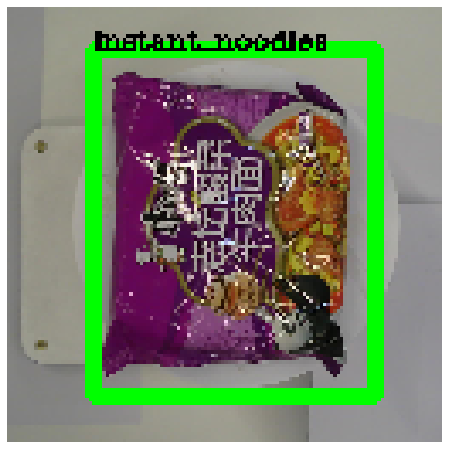

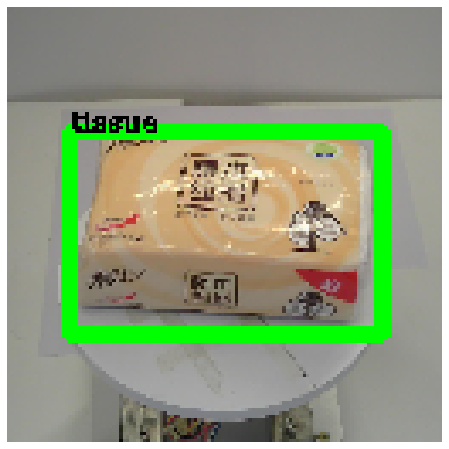

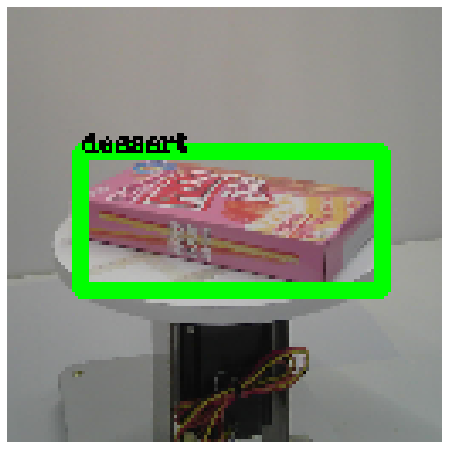

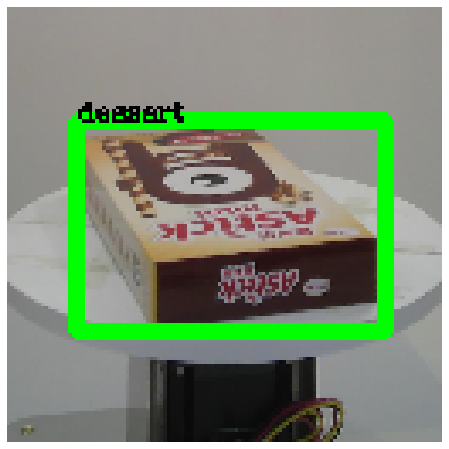

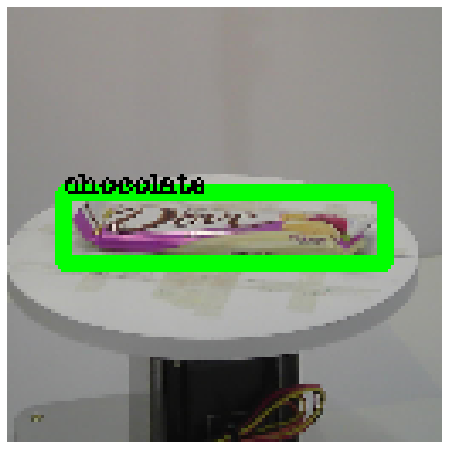

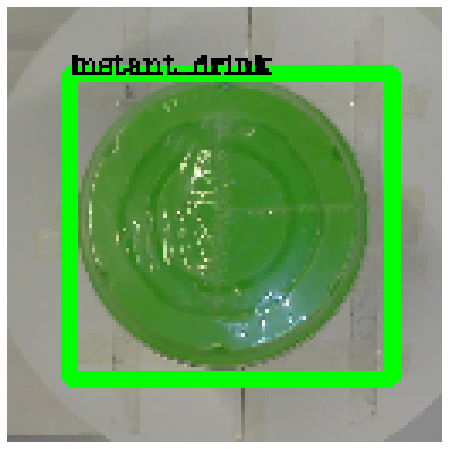

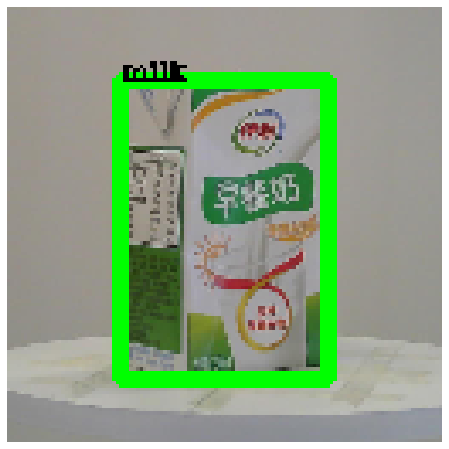

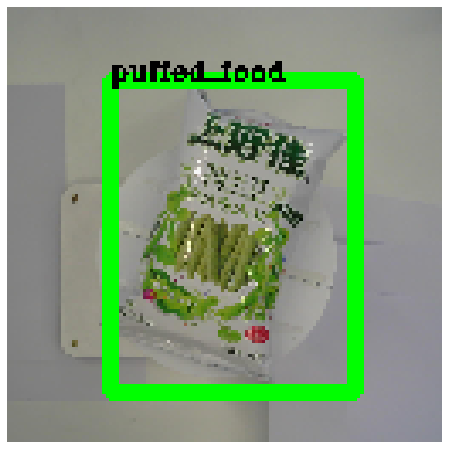

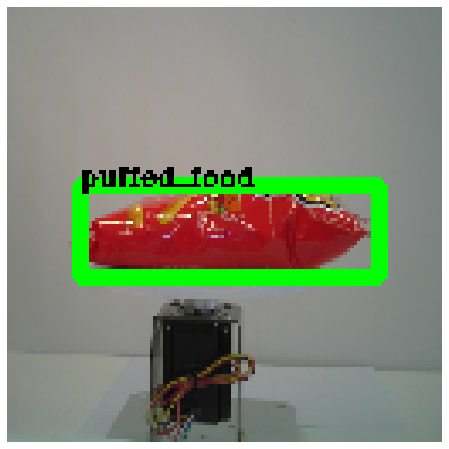

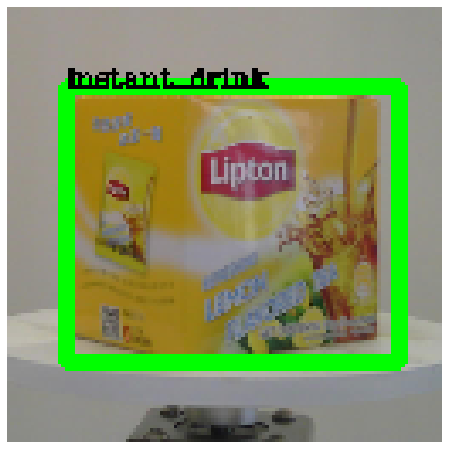

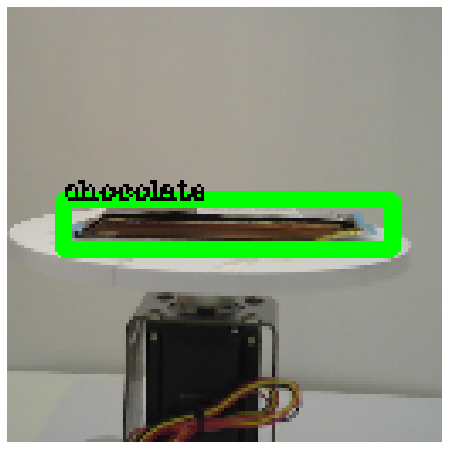

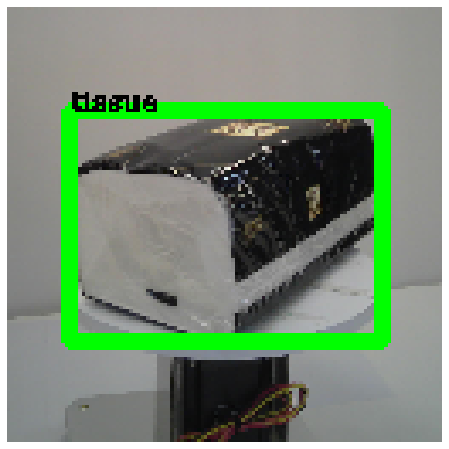

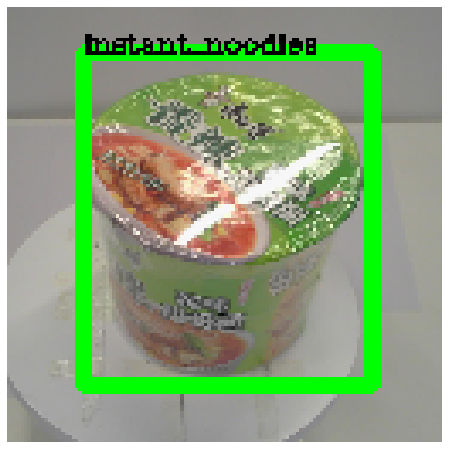

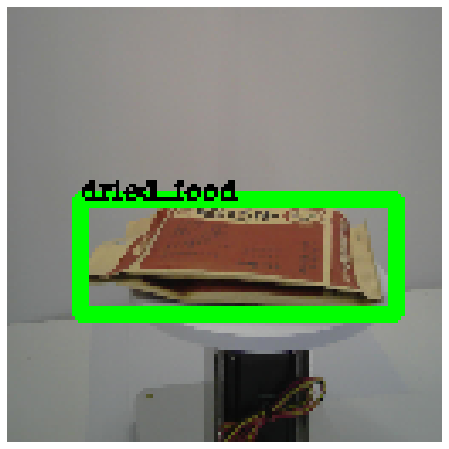

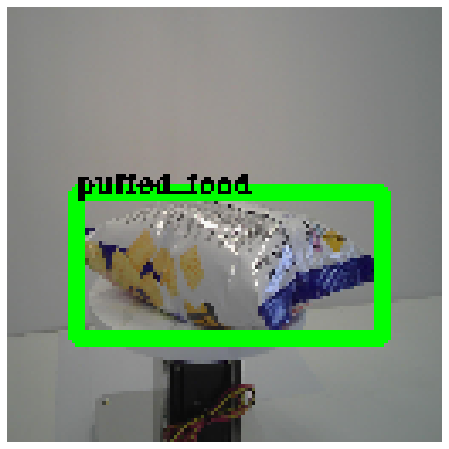

In [65]:

detection_threshold = 0.4

counter = 0
hit = 0
miss, miss_score, miss_detect = 0, 0, 0

true_labs = []
predicted_labs = []

for i in range(len(targets_true)):
    orig_image = images[i]
    target_true = targets_true[i]
    predicted = outputs[i]
    scores = predicted['scores']
    counter += 1
    if len(scores) > 0:
        max_index = scores.argmax()
        max_score = scores[max_index]

        if max_score >= detection_threshold:
            predicted_label = predicted['labels'][max_index].to(device="cpu")
            true_label = target_true['labels'][0].to(device="cpu")

            predicted_labs.append(int(predicted_label.numpy()))
            true_labs.append(int(true_label.numpy()))

            pred_label_text = text_label(int(predicted_label.numpy()))
            true_label_text = text_label(int(true_label.numpy()))

            if int(predicted_label) == int(true_label):
                hit += 1
            else:
                miss +=1

            box = predicted['boxes'][max_index]

            if counter % 100 == 0:
                plot_images([orig_image.cpu().numpy().transpose(1, 2, 0)], 
                            nrows=1, ncols=1, mode='detection', 
                            detection_boxes=[box], 
                            detection_labels=[f"{pred_label_text}"],
                            pic_name=f"{counter}",
                            dataset_format='pascal_voc')

        else:
            miss_score += 1
    else:
        miss_detect += 1


In [66]:
number_labels = mapping['labels'].tolist()
text_labels = mapping['supercategory'].tolist()

In [67]:

print(f"Overall accuracy: {hit / counter}\nMiss on not detected: {miss_detect / counter}")
print(f"Miss on low enssurance score: {miss_score / counter}\nMiss on wrong prediction: {miss / counter}\n")


Overall accuracy: 0.30852251581689616
Miss on not detected: 0.0
Miss on low enssurance score: 0.6914774841831038
Miss on wrong prediction: 0.0



In [68]:
import seaborn as sns

def make_confusion_matrix(cf,
                          file_name,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
#         group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
        group_percentages = []
        group_percentages_num = []
        for row in cf:
            for value in row / np.sum(row):
                group_percentages.append("{0:.1%}".format(value))
                group_percentages_num.append(value)
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
        stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    group_percentages_num = np.asarray(group_percentages_num).reshape(cf.shape[0],cf.shape[1])
    sns.heatmap(group_percentages_num,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    plt.savefig(file_name)

In [69]:
from sklearn.metrics import confusion_matrix


cf_matrix = confusion_matrix(true_labs, predicted_labs, normalize=None)

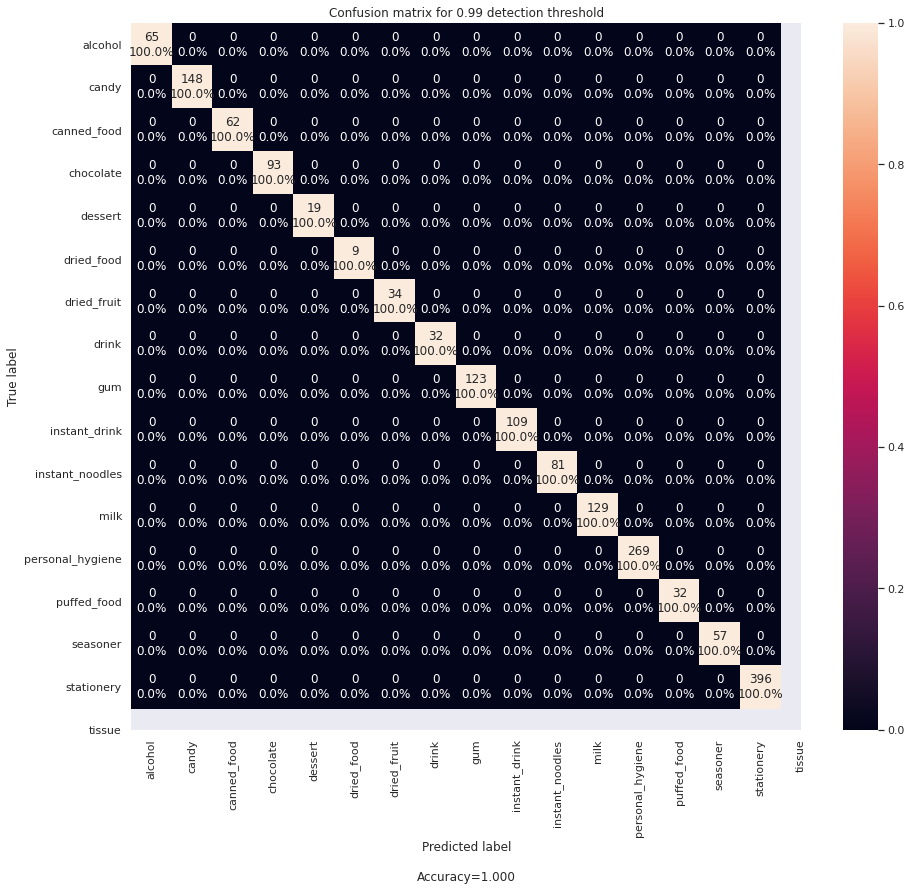

In [70]:
make_confusion_matrix(cf_matrix,
                      f'cf_th{detection_threshold}.png',
                      categories=text_labels,
                      figsize=(15, 13),
                      cmap='rocket',
                      title=f"Confusion matrix for {detection_threshold} detection threshold")